This notebook is meant to show a few examples of exploring, selecting, and retrieving data available within LINCS-CMap datasets from Google BigQuery. `cmapBQ` allows for targeted retrieval of relevant gene expression data from the resources provided by The Broad Institute and LINCS Project.

##### Credentials Setup and Package Imports

In [98]:
%pip -q install cmapBQ

Note: you may need to restart the kernel to use updated packages.


In [99]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import matplotlib.pyplot as plt

In [100]:
# 인증 파일이 저장될 경로 (디렉토리 포함)
credentials_filepath = '/Users/koyunkyung/Documents/gene_expression_lincs/content/BQ-demo-credentials.json'

# 인증 파일이 저장된 URL
url = 'https://s3.amazonaws.com/data.clue.io/api/bq_creds/BQ-demo-credentials.json'

# URL에서 인증 파일 다운로드
response = requests.get(url)
with open(credentials_filepath, 'w') as f:
    f.write(response.text)

print(f"Credentials file saved to {credentials_filepath}")

Credentials file saved to /Users/koyunkyung/Documents/gene_expression_lincs/content/BQ-demo-credentials.json


In [101]:
import cmapBQ.query as cmap_query
import cmapBQ.config as cmap_config

credentials_filepath = '/Users/koyunkyung/Documents/gene_expression_lincs/content/BQ-demo-credentials.json'

# 인증 설정
cmap_config.setup_credentials(credentials_filepath)
bq_client = cmap_config.get_bq_client()

print("BigQuery client is successfully set up!")

BigQuery client is successfully set up!


In [77]:
import cmapBQ.query as cmap_query
query = "SELECT COUNT(DISTINCT(cid)) as num_level5_sigs FROM cmap-big-table.cmap_lincs_public_views.L1000_Level5"
cmap_query.run_query(query=query, client=bq_client).result().to_dataframe()

,num_level5_sigs
0,1202208


##### Table Schema Information

In [78]:
cmap_query.list_tables()

_includes_clustered_tables: <bound method TableDirectory._includes_clustered_tables of TableDirectory(compoundinfo='cmap-big-table.cmap_lincs_public_views.compoundinfo', genetic_pertinfo='cmap-big-table.cmap_lincs_public_views.genetic_pertinfo', geneinfo='cmap-big-table.cmap_lincs_public_views.geneinfo', cellinfo='cmap-big-table.cmap_lincs_public_views.cellinfo', instinfo='cmap-big-table.cmap_lincs_public_views.instinfo', siginfo='cmap-big-table.cmap_lincs_public_views.siginfo', level3='cmap-big-table.cmap_lincs_public_views.L1000_Level3_cid', level3_rid='cmap-big-table.cmap_lincs_public_views.L1000_Level3_rid', level3_landmark='cmap-big-table.cmap_lincs_public_views.L1000_Level3_landmark', level4='cmap-big-table.cmap_lincs_public_views.L1000_Level4_cid', level4_rid='cmap-big-table.cmap_lincs_public_views.L1000_Level4_rid', level4_landmark='cmap-big-table.cmap_lincs_public_views.L1000_Level4_landmark', level5='cmap-big-table.cmap_lincs_public_views.L1000_Level5_cid', level5_rid='cmap-b

In [79]:
cmap_query.get_table_info(bq_client, 'cmap-big-table.cmap_lincs_public_views.compoundinfo') 

,column_name,data_type
0,pert_id,STRING
1,cmap_name,STRING
2,target,STRING
3,moa,STRING
4,canonical_smiles,STRING
5,inchi_key,STRING
6,compound_aliases,STRING


In [80]:
config = cmap_config.get_default_config()
compoundinfo_table = config.tables.compoundinfo

QUERY = ( 'SELECT moa, ' 
'COUNT(DISTINCT(pert_id)) AS count ' 
'FROM `{}` ' 
'GROUP BY moa')

QUERY = QUERY.format(compoundinfo_table)
cmap_query.run_query(bq_client, QUERY).result().to_dataframe()

,moa,count
0,None,31262
1,CAR agonist,2
2,ALK inhibitor,7
3,Akt inhibitor,13
4,BCL inhibitor,11
...,...,...
653,Telomerase reverse transcriptase expression in...,1
654,Gonadotropin releasing factor hormone receptor...,2
655,Gonadotropin releasing factor hormone receptor...,1
656,"Precursor for food preservatives, plasticizers...",1


In [81]:
moas = cmap_query.list_cmap_moas(bq_client)
display(moas)

,moa,count
0,None,31262
1,CAR agonist,2
2,ALK inhibitor,7
3,Akt inhibitor,13
4,BCL inhibitor,11
...,...,...
653,Telomerase reverse transcriptase expression in...,1
654,Gonadotropin releasing factor hormone receptor...,2
655,Gonadotropin releasing factor hormone receptor...,1
656,"Precursor for food preservatives, plasticizers...",1


In [82]:
targets = cmap_query.list_cmap_targets(bq_client)
display(targets.sort_values('count'))

,target,count
890,RAB9A,1
285,SOAT2,1
284,SOAT1,1
283,ACACB,1
282,ACACA,1
...,...,...
75,PTGS2,78
94,HTR2A,79
141,NR3C1,90
77,DRD2,95


In [83]:
display(
    moas[moas['moa'].str.contains('Glucocorticoid receptor agonist', na=False)]
)
display(
    targets[targets['target'].str.contains('EGFR', na=False)]
)

,moa,count
479,Glucocorticoid receptor agonist,81


,target,count
31,EGFR,39


#### Analysis 1: Comparison of MoA Concordance across Various Cell Lines

##### Compound Information Table

In [84]:
moa = 'Glucocorticoid receptor agonist'
#moa = 'EGFR inhibitor'

moa_cpinfo = cmap_query.cmap_compounds(client=bq_client,
  moa=moa, 
  #verbose=True,
)
moa_cpinfo.sample(10)

,pert_id,cmap_name,target,moa,canonical_smiles,inchi_key,compound_aliases
60,BRD-A65767837,hydrocortisone-acetate,NR3C1,Glucocorticoid receptor agonist,CC(=O)OCC(=O)[C@@]1(O)CCC2C3CCC4=CC(=O)CC[C@]4...,ALEXXDVDDISNDU-KPYZGQEZSA-N,None
67,BRD-K13688115,medrysone,NR3C1,Glucocorticoid receptor agonist,C[C@H]1C[C@H]2[C@H]3CC[C@H](C(C)=O)[C@@]3(C)C[...,GZENKSODFLBBHQ-WXWRWIGRSA-N,None
47,BRD-K14791739,fluticasone,PGR,Glucocorticoid receptor agonist,CCC(=O)O[C@]1([C@H](C)C[C@@H]2[C@H]3C[C@H](F)C...,WMWTYOKRWGGJOA-GFDKJMNNSA-N,None
59,BRD-A73635141,hydrocortisone,NR3C1,Glucocorticoid receptor agonist,CC12CC(O)C3C(CCC4=CC(=O)CCC34C)C2CCC1(O)C(=O)CO,JYGXADMDTFJGBT-UHFFFAOYSA-N,None
37,BRD-A93424738,dexamethasone-acetate,NR3C1,Glucocorticoid receptor agonist,C[C@@H]1CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C...,AKUJBENLRBOFTD-HIBZCRSPSA-N,None
64,BRD-K29173907,isoflupredone-acetate,NR3C1,Glucocorticoid receptor agonist,CC(=O)OCC(=O)[C@@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=...,ZOCUOMKMBMEYQV-GSLJADNHSA-N,None
17,BRD-A58753560,budesonide,NR3C1,Glucocorticoid receptor agonist,CCCC1O[C@@H]2C[C@H]3[C@H]4CCC5=CC(=O)C=C[C@]5(...,VOVIALXJUBGFJZ-JQDNLURHSA-N,None
41,BRD-A01346607,flumetasone,NR3C1,Glucocorticoid receptor agonist,C[C@@H]1CC2C3C[C@H](F)C4=CC(=O)C=C[C@]4(C)[C@@...,WXURHACBFYSXBI-DRBBXQFKSA-N,None
19,BRD-A82238138,budesonide,NR3C1,Glucocorticoid receptor agonist,CCCC1OC2CC3C4CCC5=CC(=O)C=CC5(C)C4C(O)CC3(C)C2...,VOVIALXJUBGFJZ-UHFFFAOYSA-N,None
62,BRD-A25143711,hydrocortisone-valerate,NR3C1,Glucocorticoid receptor agonist,CCCCC(=O)O[C@@]1(CCC2C3CCC4=CC(=O)CC[C@]4(C)C3...,FZCHYNWYXKICIO-BXLKFAEVSA-N,None


In [85]:
moa_cps = moa_cpinfo.cmap_name.unique()
moa_cps

array(['dexamethasone', 'mometasone', 'flumetasone', 'alclometasone',
       'amcinonide', 'beclometasone', 'beclomethasone-dipropionate',
       'betamethasone', 'betamethasone-acetate', 'betamethasone-valerate',
       'budesonide', 'ciclesonide', 'clobetasol', 'clocortolone',
       'cortisol', 'cortisone-acetate', 'deflazacort',
       'dexamethasone-acetate', 'diflorasone', 'fludrocortisone-acetate',
       'fluocinolone-acetonide', 'fluticasone', 'fluticasone-propionate',
       'halcinonide', 'halometasone', 'hydrocortisone',
       'hydrocortisone-acetate', 'hydrocortisone-hemisuccinate',
       'hydrocortisone-valerate', 'isoflupredone',
       'isoflupredone-acetate', 'loteprednol', 'medrysone',
       'methylprednisolone', 'piretanide', 'prednisolone-acetate',
       'prednisolone-hemisuccinate', 'prednisone', 'rimexolone',
       'triamcinolone'], dtype=object)

##### Cell Line Information

In [86]:
core_cell_lines = ['A375', 'A549', 'HCC515', 'HEPG2', 'MCF7', 'PC3', 'VCAP', 'HT29', 'HA1E']

core_cellinfo = cmap_query.cmap_cell(bq_client, 
  cell_iname=core_cell_lines, 
  verbose=True,
)
core_cellinfo.head(10)

Table: 
 cmap-big-table.cmap_lincs_public_views.cellinfo
Query:
 SELECT * FROM cmap-big-table.cmap_lincs_public_views.cellinfo WHERE cell_iname in UNNEST(['A375', 'A549', 'HCC515', 'HEPG2', 'MCF7', 'PC3', 'VCAP', 'HT29', 'HA1E'])


,cell_iname,cellosaurus_id,donor_age,donor_age_death,donor_disease_age_onset,doubling_time,growth_medium,provider_catalog_id,feature_id,cell_type,donor_ethnicity,donor_sex,donor_tumor_phase,cell_lineage,primary_disease,subtype,provider_name,growth_pattern,ccle_name,cell_alias
0,HCC515,CVCL_5136,None,<NA>,None,None,None,None,None,tumor,Unknown,F,Unknown,lung,lung cancer,carcinoma,None,adherent,HCC515_LUNG,HCC0515
1,HA1E,None,None,<NA>,None,60,MEM-ALPHA (Invitrogen A1049001) supplemented w...,None,None,normal,Unknown,Unknown,Unknown,kidney,normal kidney sample,normal kidney sample,None,unknown,HA1E_KIDNEY,None
2,A549,CVCL_0023,58,<NA>,None,48,F-12K ATCC catalog # 3-24,CCL-185,c-4,tumor,Caucasian,M,Primary,lung,lung cancer,non small cell carcinoma,ATCC,adherent,A549_LUNG,A 549
3,A375,CVCL_0132,54,<NA>,None,36,DMEM Invitrogen catalog # 11995-65,CRL-1619,c-127,tumor,Unknown,F,Metastatic,skin,skin cancer,melanoma,ATCC,adherent,A375_SKIN,A 375|A-375
4,HT29,CVCL_0320,44,<NA>,None,36,McCoy's 5A Invitrogen catalog # 166-82,HTB-38,c-272,tumor,Caucasian,F,Primary,large_intestine,colon cancer,adenocarcinoma,ATCC,adherent,HT29_LARGE_INTESTINE,HT 29
5,HEPG2,CVCL_0027,15,<NA>,None,84,EMEM ATCC catalog # 3-23,HB-8065,None,tumor,Caucasian,M,Primary,liver,liver cancer,carcinoma,ATCC,adherent,HEPG2_LIVER,Hep G2|HEP-G2
6,MCF7,CVCL_0031,40,<NA>,None,72,EMEM ATCC catalog # 3-23,HTB-22,c-438,tumor,Caucasian,F,Metastatic,breast,breast cancer,adenocarcinoma,ATCC,adherent,MCF7_BREAST,IBMF-7
7,PC3,CVCL_0035,62,<NA>,None,72,F-12K ATCC catalog # 3-24,CRL-1435,c-214,tumor,Caucasian,M,Metastatic,prostate,prostate cancer,adenocarcinoma,ATCC,mix,PC3_PROSTATE,PC.3|PC-3
8,VCAP,CVCL_2235,None,<NA>,None,220,DMEM ATCC catalog # 3-22,None,None,tumor,Caucasian,M,Metastatic,prostate,prostate cancer,adenocarcinoma,ATCC,adherent,VCAP_PROSTATE,Vcap


##### Query Siginfo

In [87]:
sample_cell_lines = list(core_cellinfo.cell_iname.unique()) #core_cell_lines

sample_compounds = list(moa_cps)
print("Compounds: {}".format(sample_compounds))
print("Cell Lines: {}".format(sample_cell_lines))

siginfo_sample = cmap_query.cmap_sig(     #Query the siginfo table
    bq_client, 
    cmap_name = sample_compounds,
    cell_iname = sample_cell_lines,
    return_fields = 'all'
)

siginfo_sample = siginfo_sample.loc[     #Filter returned table 
    (siginfo_sample.nsample >= 3) &
    (siginfo_sample.pert_dose >= 10) &
    (siginfo_sample.pert_itime.eq('24 h'))
]


siginfo_sample = siginfo_sample.merge(core_cellinfo, on='cell_iname') #join with cellinfo table to get cell lineage information
siginfo_sample.sample(5)

Compounds: ['dexamethasone', 'mometasone', 'flumetasone', 'alclometasone', 'amcinonide', 'beclometasone', 'beclomethasone-dipropionate', 'betamethasone', 'betamethasone-acetate', 'betamethasone-valerate', 'budesonide', 'ciclesonide', 'clobetasol', 'clocortolone', 'cortisol', 'cortisone-acetate', 'deflazacort', 'dexamethasone-acetate', 'diflorasone', 'fludrocortisone-acetate', 'fluocinolone-acetonide', 'fluticasone', 'fluticasone-propionate', 'halcinonide', 'halometasone', 'hydrocortisone', 'hydrocortisone-acetate', 'hydrocortisone-hemisuccinate', 'hydrocortisone-valerate', 'isoflupredone', 'isoflupredone-acetate', 'loteprednol', 'medrysone', 'methylprednisolone', 'piretanide', 'prednisolone-acetate', 'prednisolone-hemisuccinate', 'prednisone', 'rimexolone', 'triamcinolone']
Cell Lines: ['HCC515', 'HA1E', 'A549', 'A375', 'HT29', 'HEPG2', 'MCF7', 'PC3', 'VCAP']


,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,donor_ethnicity,donor_sex,donor_tumor_phase,cell_lineage,primary_disease,subtype,provider_name,growth_pattern,ccle_name,cell_alias
315,f1b6,10.0,10.0,uM,10 uM,24 h,24.0,h,A549,BRD-K31627533,...,Caucasian,M,Primary,lung,lung cancer,non small cell carcinoma,ATCC,adherent,A549_LUNG,A 549
426,f1b4,10.0,10.0,uM,10 uM,24 h,24.0,h,MCF7,BRD-K97810537,...,Caucasian,F,Metastatic,breast,breast cancer,adenocarcinoma,ATCC,adherent,MCF7_BREAST,IBMF-7
360,b5,10.0,10.0,uM,10 uM,24 h,24.0,h,PC3,BRD-K56515112,...,Caucasian,M,Metastatic,prostate,prostate cancer,adenocarcinoma,ATCC,mix,PC3_PROSTATE,PC.3|PC-3
326,b22,10.0,10.0,uM,10 uM,24 h,24.0,h,HA1E,BRD-K35245662,...,Unknown,Unknown,Unknown,kidney,normal kidney sample,normal kidney sample,None,unknown,HA1E_KIDNEY,None
5,b42,10.0,10.0,uM,10 uM,24 h,24.0,h,MCF7,BRD-K76747609,...,Caucasian,F,Metastatic,breast,breast cancer,adenocarcinoma,ATCC,adherent,MCF7_BREAST,IBMF-7


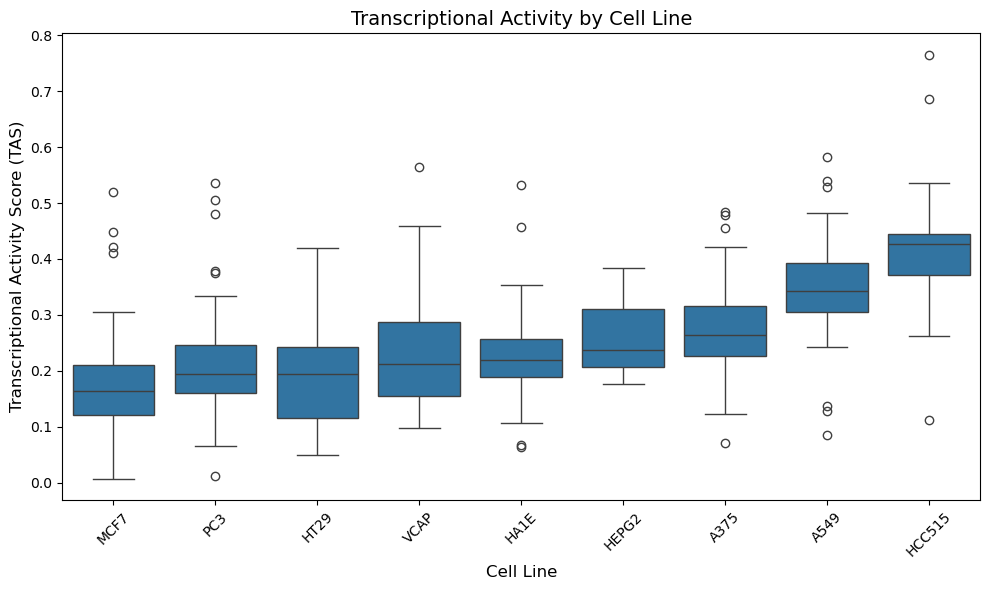

In [88]:
# Step 1: TAS 열을 숫자형으로 변환하고 NaN 제거
siginfo_sample['tas'] = pd.to_numeric(siginfo_sample['tas'], errors='coerce')
siginfo_sample = siginfo_sample.dropna(subset=['tas'])

# Step 2: Cell Iname 열을 문자열로 변환
siginfo_sample['cell_iname'] = siginfo_sample['cell_iname'].astype(str)

# Step 3: TAS의 중간값으로 Cell Iname 정렬
# GroupBy 후 median을 계산하고 인덱스를 정렬
grouped = siginfo_sample.groupby('cell_iname')['tas'].median()
sorted_index = grouped.sort_values().index

# Step 4: Boxplot 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 조정

sns.boxplot(
    data=siginfo_sample,
    x='cell_iname',
    y='tas',
    order=sorted_index,
    dodge=False
)

# Step 5: 그래프 꾸미기
plt.title("Transcriptional Activity by Cell Line", fontsize=14)
plt.xlabel("Cell Line", fontsize=12)
plt.ylabel("Transcriptional Activity Score (TAS)", fontsize=12)
plt.xticks(rotation=45)  # Cell Line 라벨 기울이기
plt.tight_layout()  # 그래프 레이아웃 조정
plt.show()

##### Numerical Data

In [89]:
sig_ids = siginfo_sample.sig_id.unique() #sig_ids are unique for each signature and relates siginfo table to numerical data

sample_data_numerical = cmap_query.cmap_matrix(bq_client,
    data_level='level5',
    feature_space='landmark', #Choices ['landmark', 'bing', 'aig']
    cid=list(sig_ids), #columns are signatures
)

print( sample_data_numerical.data_df.shape )

Running query ... (1/1)
Total bytes processed: 0.0B
Total bytes billed: 0.0B
Pivoting Dataframes to GCT objects
Complete
(978, 434)


In [90]:
corr_matrix = sample_data_numerical.data_df.corr()
print(corr_matrix.shape)

(434, 434)


In [91]:
import scipy
import scipy.cluster.hierarchy as sch
import numpy as np


def get_off_diagonals(matrix):
  """
  Extract off-diagonal elements of matrix as list of values

  Parameters
  ----------
  matrix: pandas.DataFrame or numpy.ndarray, NxN matrix
  
  Returns
  -------
  """
  return matrix.where(
    np.triu(np.ones(matrix.shape).astype(bool), k=1)
  ).stack().reset_index(drop=True)

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

def get_subplot_dimensions(num_plots):
    if num_plots % 4 == 0:
      return num_plots//4, 4
    elif num_plots % 3 == 0:
      return num_plots//3, 3
    elif num_plots % 2 == 0:
      return num_plots//2, 2
    elif num_plots % 1 == 0:
      return num_plots//1, 1

Histograms

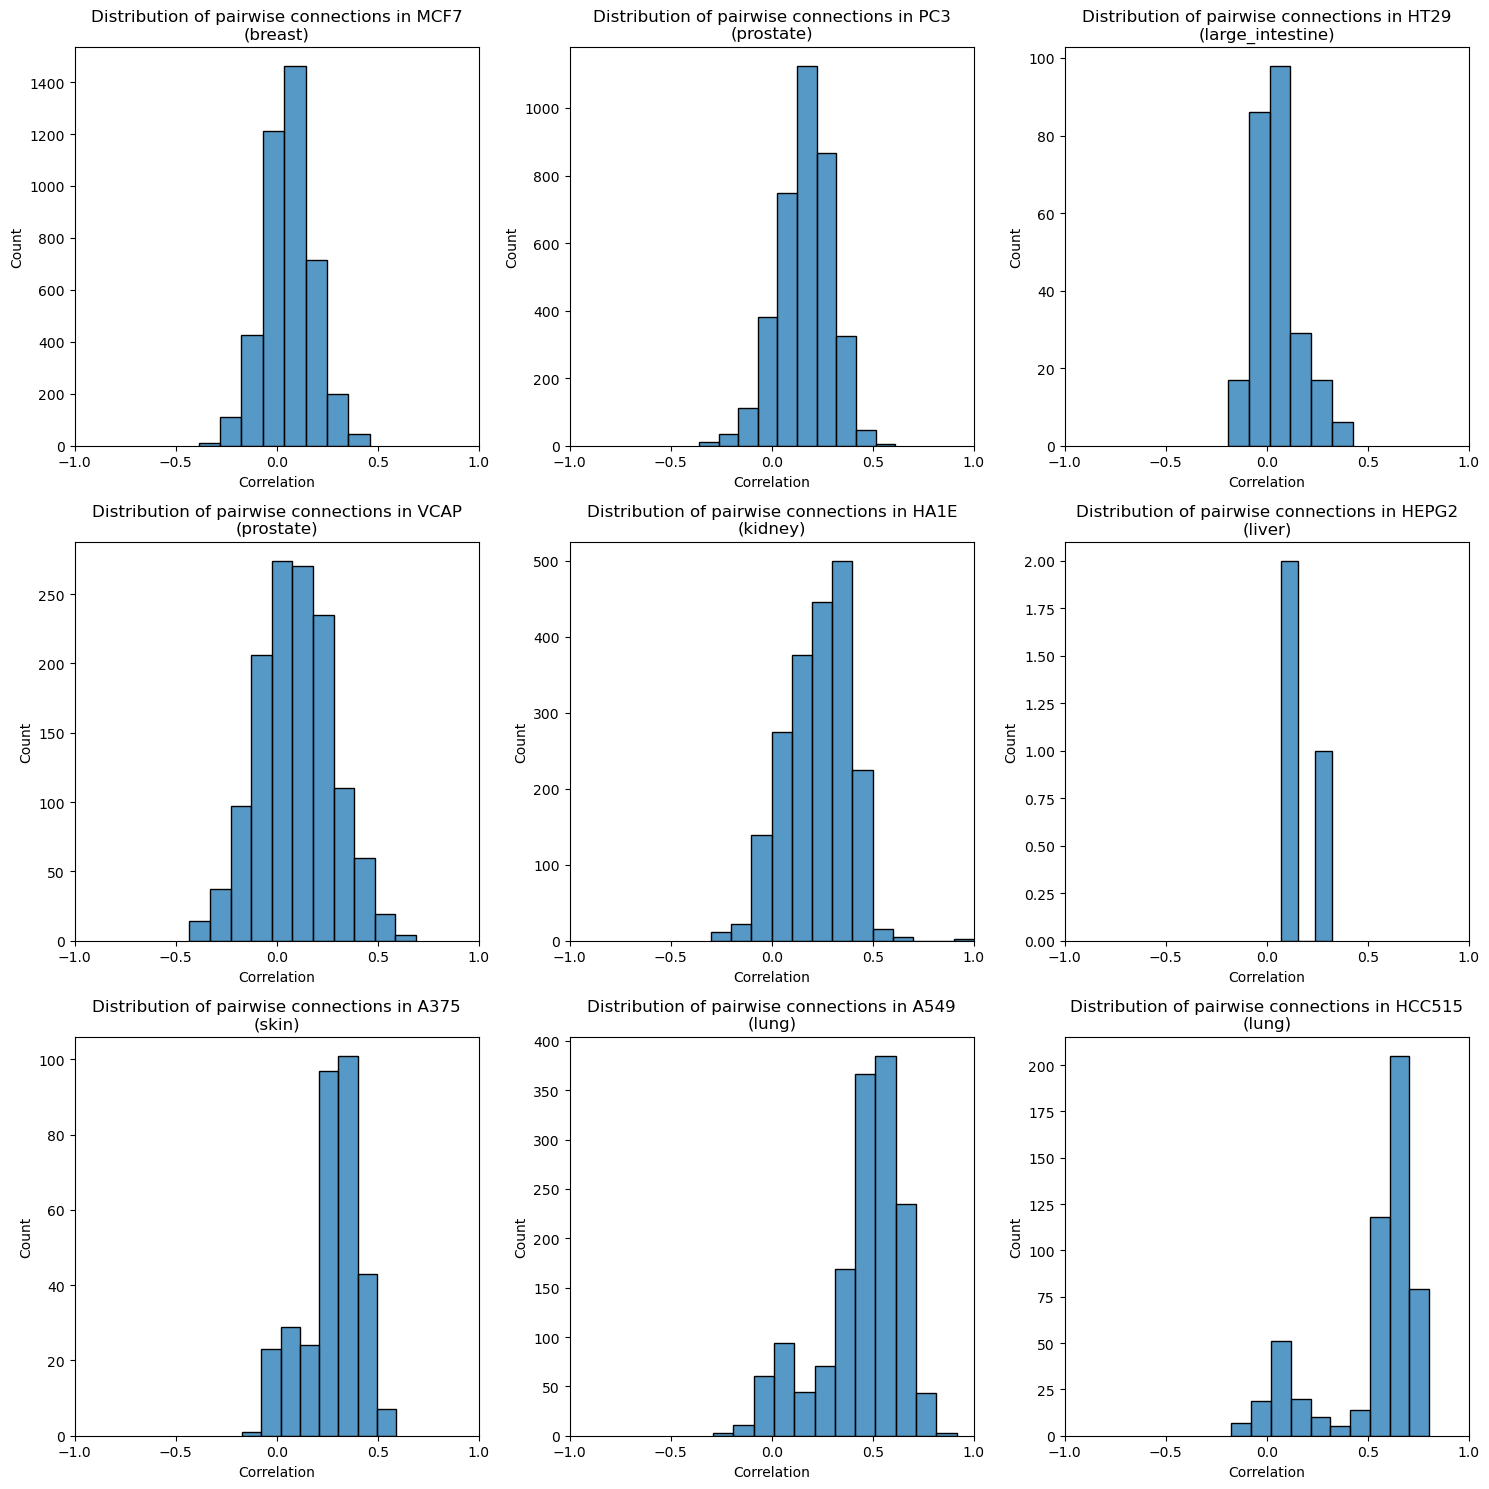

In [92]:
# 데이터 정리
siginfo_sample['tas'] = pd.to_numeric(siginfo_sample['tas'], errors='coerce')
siginfo_sample = siginfo_sample.dropna(subset=['tas'])
siginfo_sample['cell_iname'] = siginfo_sample['cell_iname'].astype(str)

# cell_iname으로 그룹화 후 median 계산
grouped_median = siginfo_sample.groupby('cell_iname')['tas'].median()
sorted_cell_list = grouped_median.sort_values().index  # cell_iname 정렬

# Plot 설정
lineage_list = []
dist_list = []
subplot_size = 5
nrows, ncols = get_subplot_dimensions(len(sorted_cell_list))
fig_dist, axes_dist = plt.subplots(nrows, ncols, figsize=(subplot_size * ncols, subplot_size * nrows))

# 각 cell_iname에 대해 작업
for i, cell in enumerate(sorted_cell_list):
    # Lineage 정보 가져오기
    lineage = core_cellinfo.loc[
        core_cellinfo.cell_iname.eq(cell)
    ].cell_lineage.unique()[0]  # Cell Lineage 정보

    # Cell Line에 해당하는 sig_ids 가져오기
    cell_sig_ids = siginfo_sample.loc[
        siginfo_sample.cell_iname.eq(cell)
    ].sig_id.unique()

    # Cell Line의 상관 행렬 가져오기
    cell_corrs = corr_matrix.loc[cell_sig_ids, cell_sig_ids]

    # Cluster (optional: 주석 처리됨)
    # cell_corrs = cluster_corr(cell_corrs)

    # Off-diagonal 값 추출
    dist = get_off_diagonals(cell_corrs)

    # 결과 저장
    dist_list.append(dist)
    lineage_list.append(lineage)

    # 히스토그램 플롯
    sns.histplot(
        dist,
        binwidth=0.1,
        ax=axes_dist[i // ncols][i % ncols]
    )
    axes_dist[i // ncols][i % ncols].set_title(
        f'Distribution of pairwise connections in {cell}\n({lineage})'
    )
    axes_dist[i // ncols][i % ncols].set_xlim(-1, 1)
    axes_dist[i // ncols][i % ncols].set_xlabel('Correlation')
    axes_dist[i // ncols][i % ncols].set_xticks([-1, -0.5, 0, 0.5, 1])

# 레이아웃 조정 및 플롯 표시
plt.tight_layout()
plt.show()


Boxplots

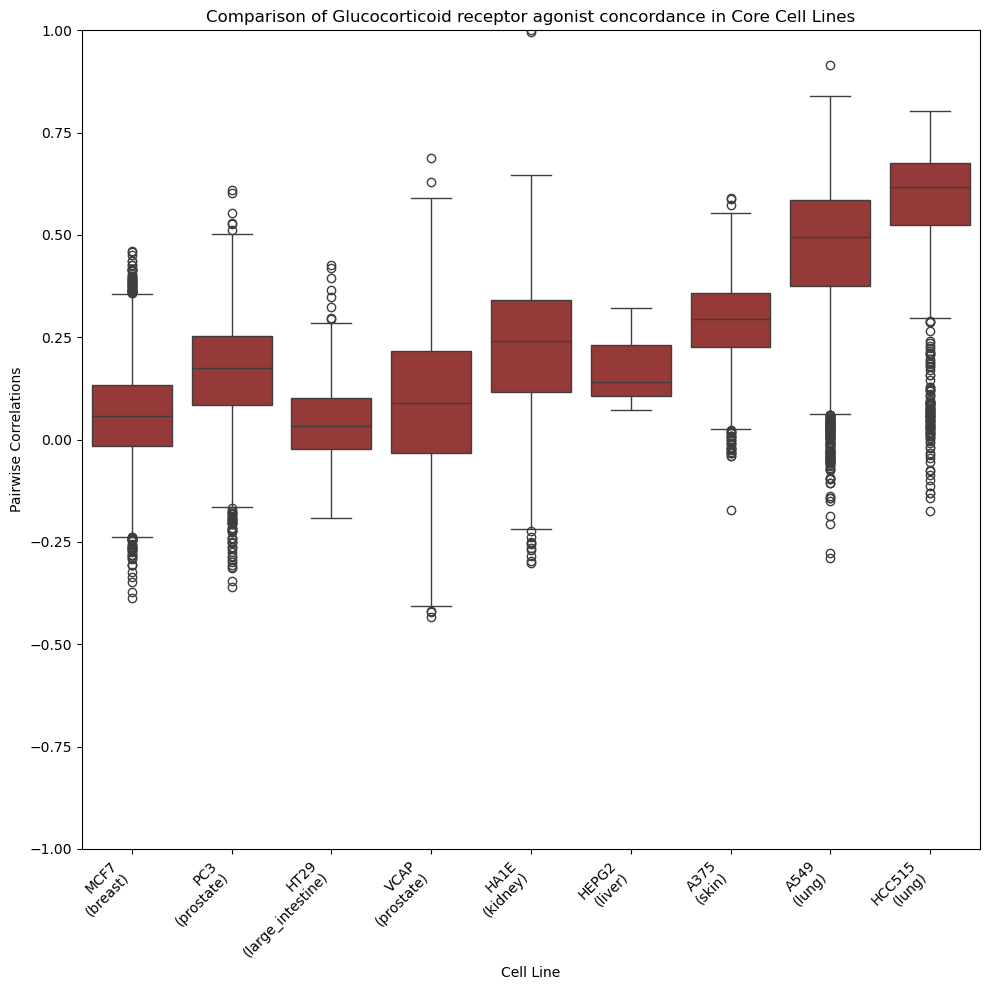

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(10, 10))

# Step 1: dist_list를 데이터프레임으로 변환
# dist_list와 cell_list를 데이터프레임으로 변환
data_for_plot = []
cell_list = grouped_median.sort_values().index.tolist()
for i, dist in enumerate(dist_list):
    for value in dist:
        data_for_plot.append({"Cell Line": cell_list[i], "Correlation": value, "Lineage": lineage_list[i]})

df = pd.DataFrame(data_for_plot)


# Step 2: 컬러 팔레트 생성 (각 lineage에 맞는 색상 매핑)
unique_lineages = df["Lineage"].unique()
colors_list = dict(zip(unique_lineages, ['brown', 'red', 'orange', 'magenta', 'blue', 'cyan', 'green']))

# Step 3: 박스플롯 그리기
sns.boxplot(
    data=df,
    x="Cell Line",
    y="Correlation",
    palette=[colors_list[lineage] for lineage in df["Lineage"]],
)

# Step 4: x축 라벨 생성 및 설정
labels = [f"{cell}\n({lineage})" for cell, lineage in zip(cell_list, lineage_list)]
plt.xticks(ticks=np.arange(len(cell_list)), labels=labels, rotation=45, ha="right")

# Step 5: 그래프 설정
plt.ylabel("Pairwise Correlations")
plt.xlabel("Cell Line")
plt.ylim([-1, 1])
plt.title(f"Comparison of {moa} concordance in Core Cell Lines")

plt.tight_layout()
plt.show()


Heatmaps

In [94]:
# color map configuration

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

red_blue_map = cm.get_cmap('RdBu_r', 256)
tau_red_blue_90 = red_blue_map(np.linspace(0,1,200))
white = np.array([1, 1, 1, 1])
tau_red_blue_90[70:130, :] = white
tau_red_blue_90 = ListedColormap(tau_red_blue_90)

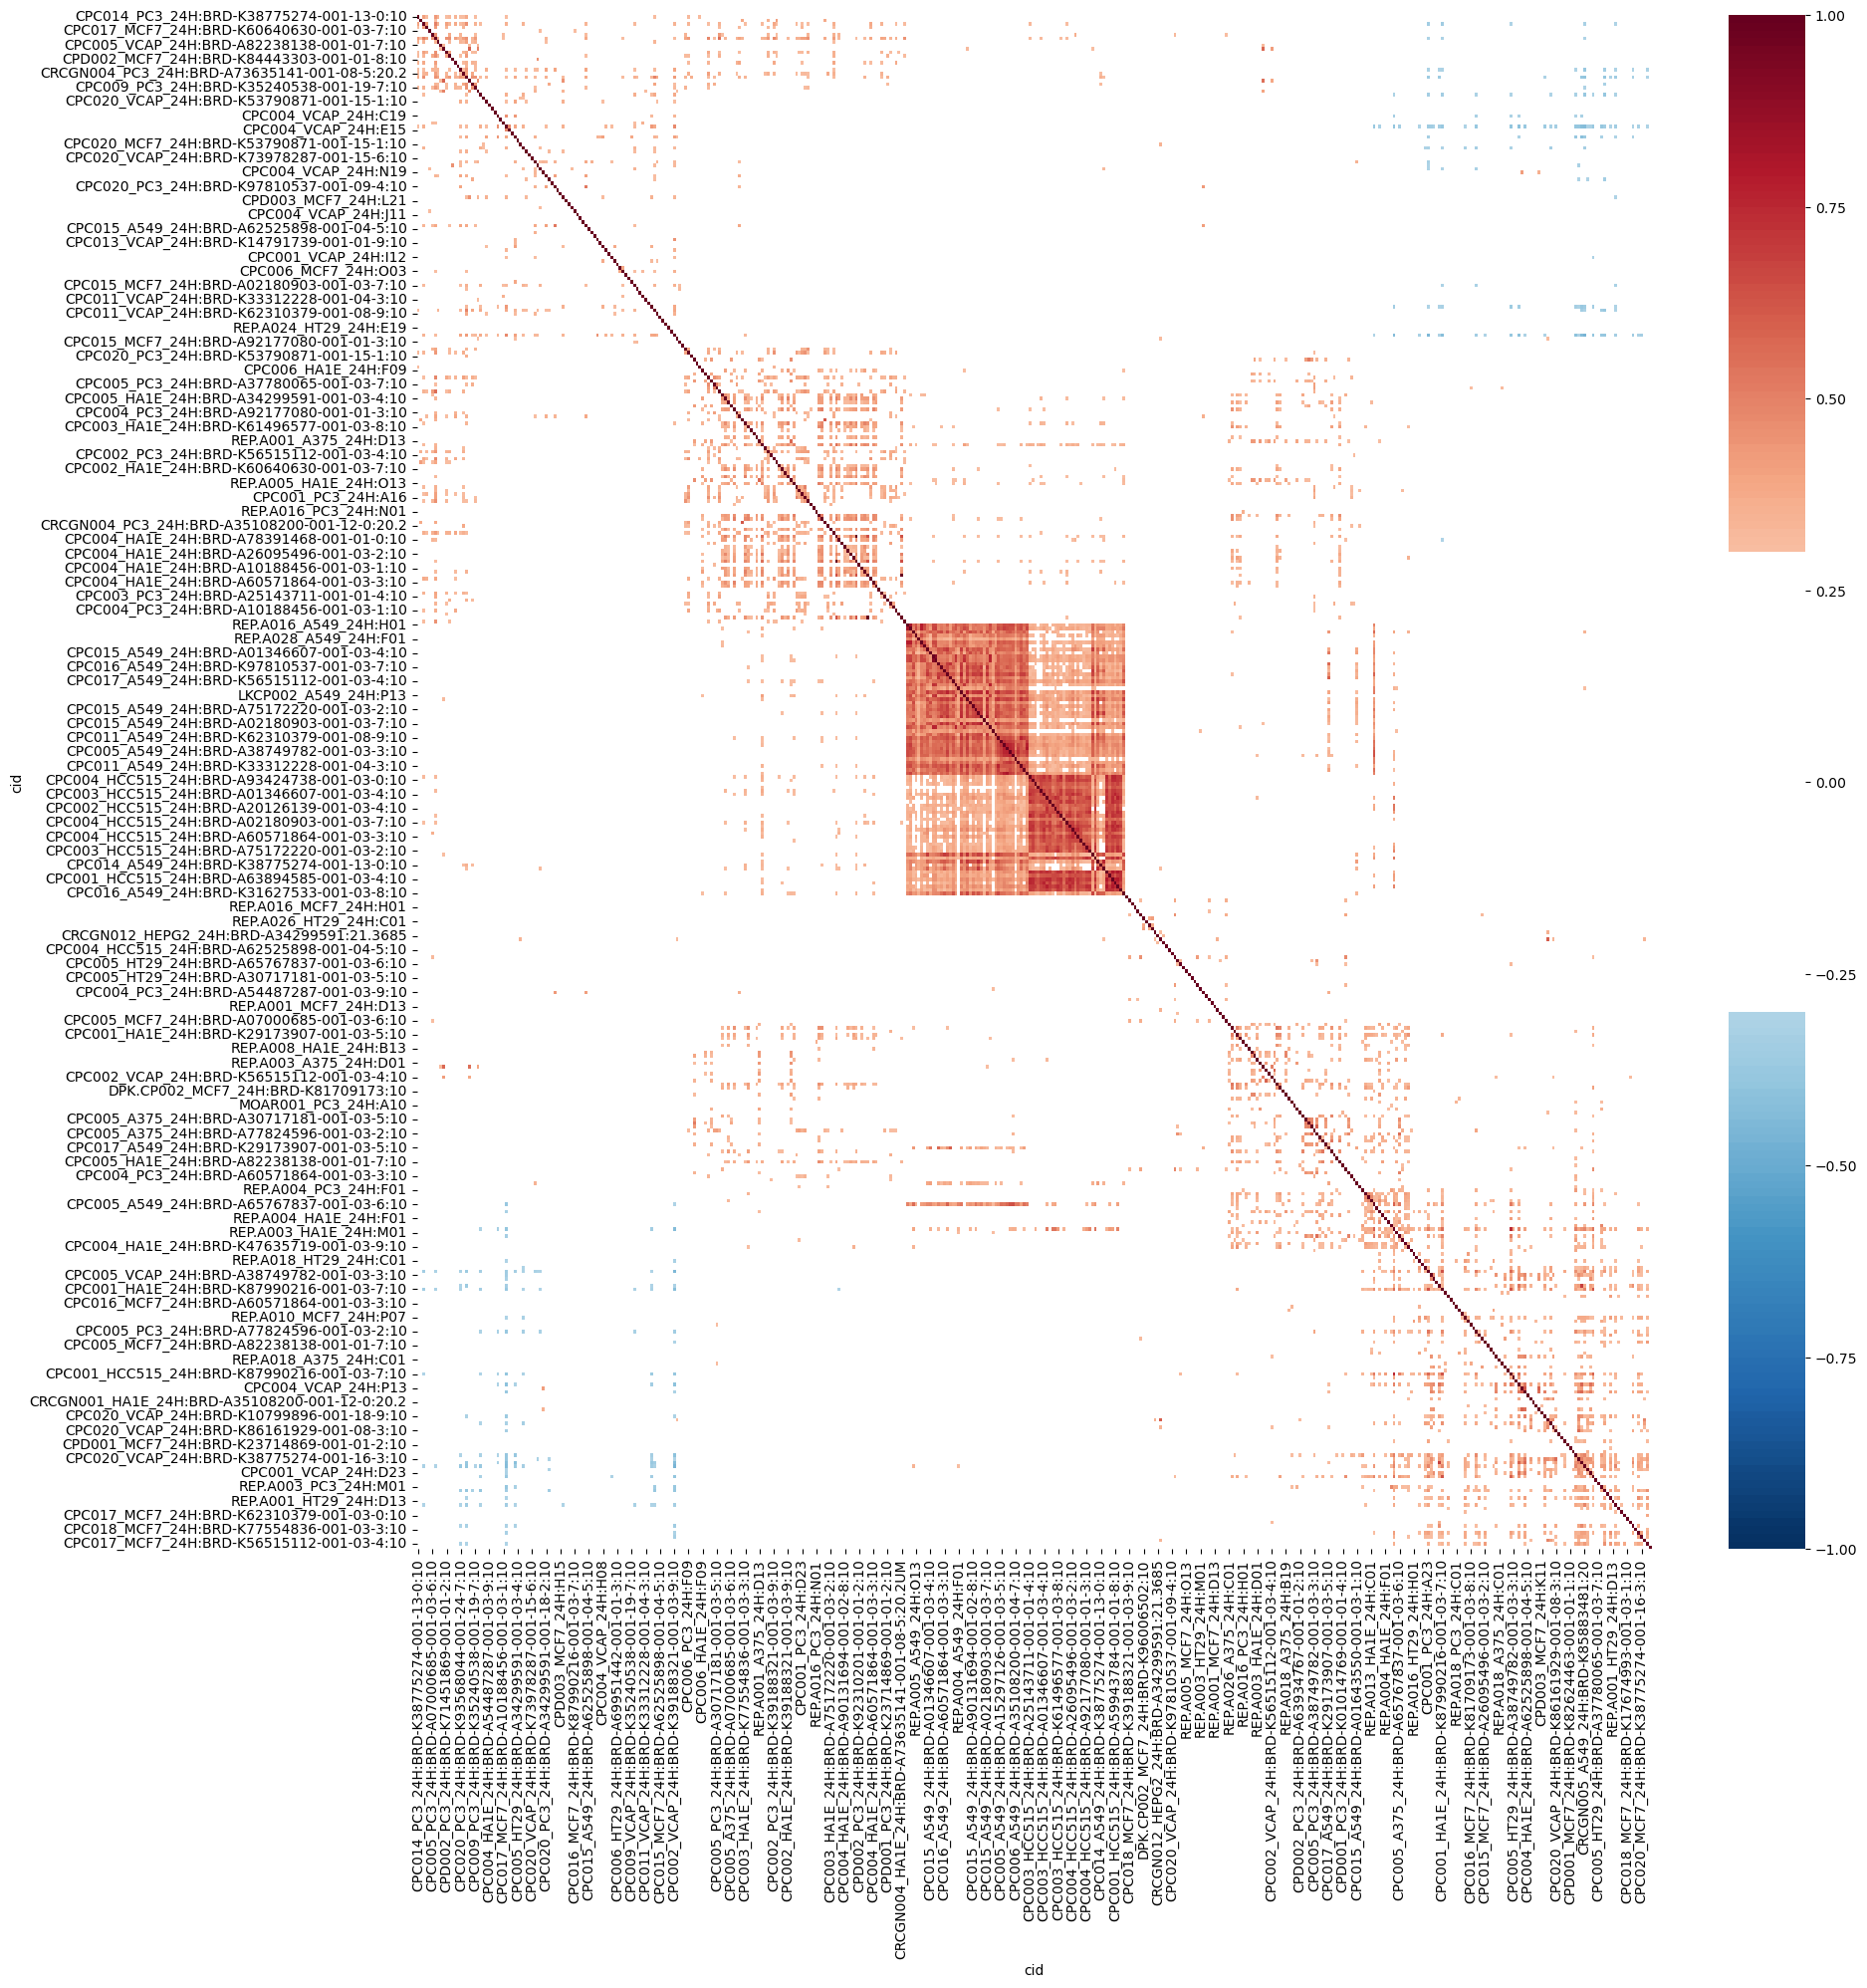

In [95]:
# full correlation matrix

clustered_matrix = cluster_corr(sample_data_numerical.data_df.corr())
plt.figure(figsize=(20,20))
sns.heatmap(clustered_matrix, cmap=tau_red_blue_90, vmin=-1, vmax=1)
plt.show()

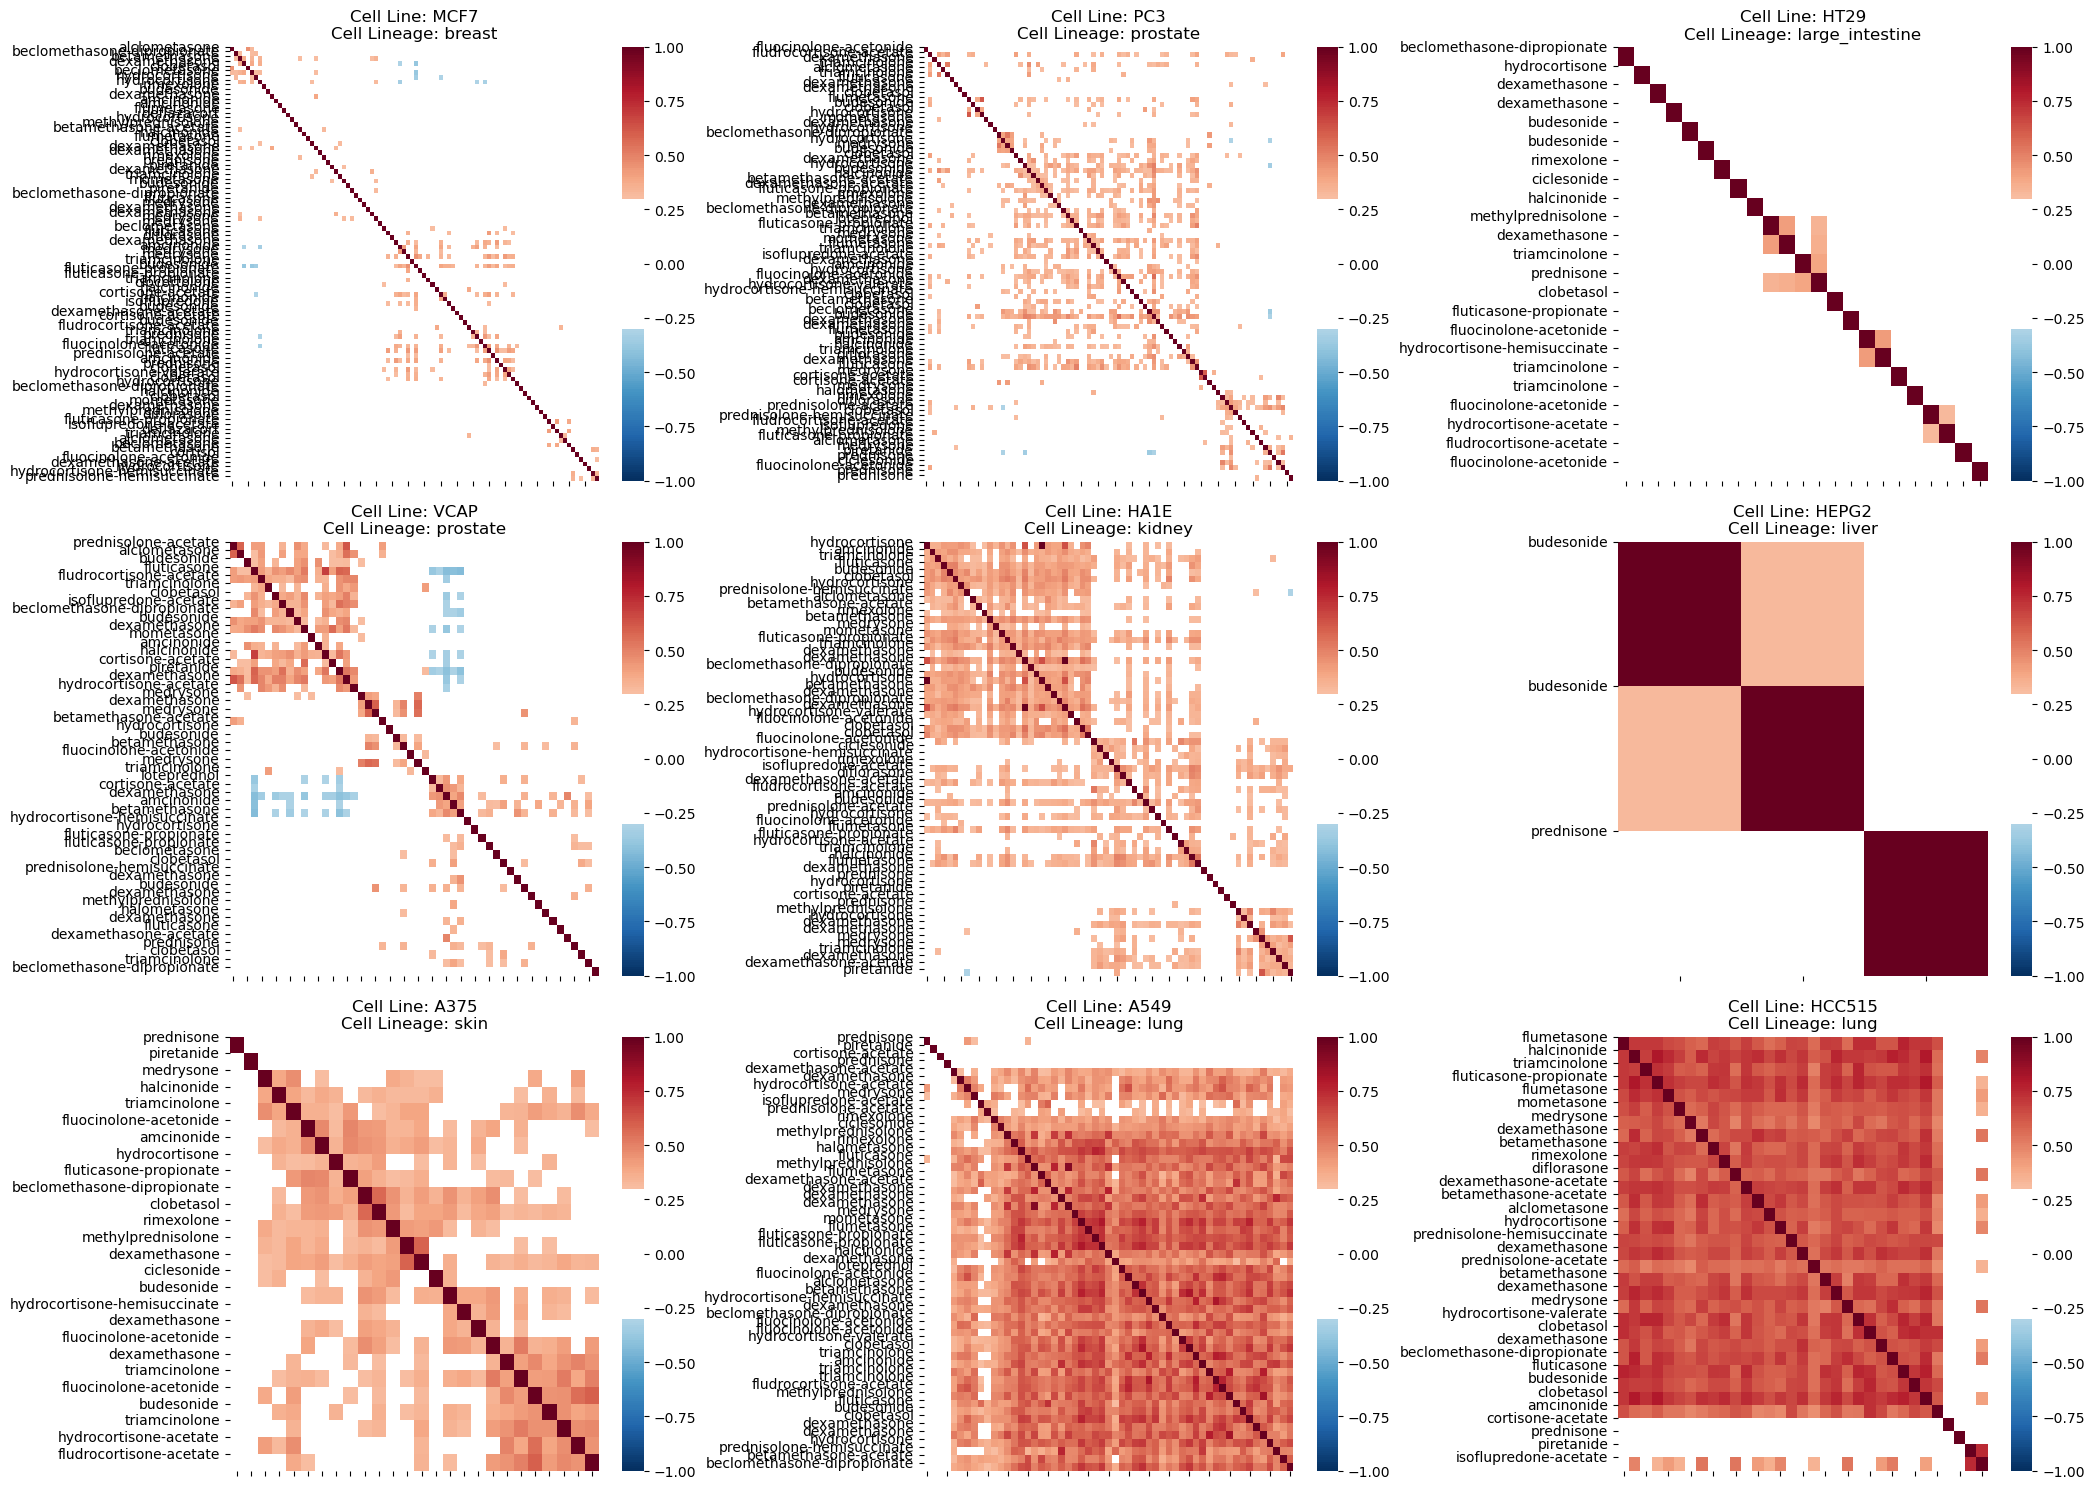

In [96]:
# pairwise correlation by cell line

# Step 1: 데이터 정리
siginfo_sample['tas'] = pd.to_numeric(siginfo_sample['tas'], errors='coerce')
siginfo_sample = siginfo_sample.dropna(subset=['tas'])
siginfo_sample['cell_iname'] = siginfo_sample['cell_iname'].astype(str)
grouped_median = siginfo_sample.groupby('cell_iname')['tas'].median()
cell_list = grouped_median.sort_values().index

# Step 2: 서브플롯 설정
nrows, ncols = get_subplot_dimensions(len(cell_list))
subplot_size = 5
fig_hm, axes_hm = plt.subplots(nrows, ncols, figsize=(subplot_size * ncols * 1.4, subplot_size * nrows))

# Step 3: 각 Cell Line에 대한 Heatmap 생성
for i, cell in enumerate(cell_list):
    # Cell Lineage 정보 가져오기
    lineage = core_cellinfo.loc[
        core_cellinfo.cell_iname.eq(cell)
    ].cell_lineage.unique()[0]

    # Cell Line에 해당하는 siginfo 가져오기
    cell_siginfo = siginfo_sample.loc[siginfo_sample.cell_iname.eq(cell)]
    cell_sig_ids = cell_siginfo.sig_id.unique()

    # Cell Correlation Matrix 가져오기
    cell_corrs = corr_matrix.loc[cell_sig_ids, cell_sig_ids]

    # Clustering (optional: cluster_corr 함수 필요)
    if 'cluster_corr' in globals():
        cell_corrs = cluster_corr(cell_corrs)

    # Heatmap 플롯
    sns.heatmap(
        cell_corrs,
        cmap=tau_red_blue_90, 
        vmin=-1, 
        vmax=1,
        ax=axes_hm[i // ncols][i % ncols]
    )

    # Compound 이름 추가 (y축 눈금과 레이블 정렬)
    sorted_siginfo = cell_siginfo.set_index('sig_id').loc[cell_corrs.index]
    yticklabels = sorted_siginfo.cmap_name  # y축 레이블
    yticks = range(len(cell_corrs))  # y축 눈금 위치 설정
    
    axes_hm[i // ncols][i % ncols].set_yticks(yticks)
    axes_hm[i // ncols][i % ncols].set_yticklabels(yticklabels, rotation=0)

    # 축 레이블 및 제목 설정
    axes_hm[i // ncols][i % ncols].set_xticklabels([])
    axes_hm[i // ncols][i % ncols].set_xlabel('')
    axes_hm[i // ncols][i % ncols].set_ylabel('')
    axes_hm[i // ncols][i % ncols].set_title(f'Cell Line: {cell}\nCell Lineage: {lineage}')

# Step 4: 레이아웃 조정
plt.tight_layout()
plt.show()

#### Analysis 2: Gene Mod

In [72]:
target = 'NR3C1'
target_info = cmap_query.cmap_genes(bq_client, gene_symbol='NR3C1')
target_gene_id = target_info.gene_id.item()

In [97]:
def genemod_histograms_by_cell(data, 
                               info,
                               cellinfo,
                               cell_order,
                               target,
                               level='level5', 
                               xlim=[-10, 10],
                               ylim=[0,10], 
                               metric_label='Normalized expression', 
                               plot_title=''):
    dist_list = []
    lineage_list = []

    subplot_size = 5
    nrows, ncols = get_subplot_dimensions(len(cell_order))
    fig_dist, axes_dist = plt.subplots(nrows, ncols, figsize=(subplot_size*ncols,subplot_size*nrows))

    for i,cell in enumerate(cell_order):
        lineage = cellinfo.loc[
              cellinfo.cell_iname.eq(cell)
            ].cell_lineage.unique()[0]  #Lineage information for cell line

        if level == 'level5':
          cell_sig_ids = info.loc[
            info.cell_iname.eq(cell)
          ].sig_id.unique()  #Get sig_ids for cell line
        elif level == 'level3':
          cell_sig_ids = info.loc[
            info.cell_iname.eq(cell)
          ].sample_id.unique()  #Get sig_ids for cell line
        
        cell_genemod = data.loc[str(target_gene_id), cell_sig_ids] #Extract correlations for cell line
  
        sns.histplot(cell_genemod, 
                    binwidth=0.1,
                    ax=axes_dist[i // ncols][i % ncols])
        
        axes_dist[i // ncols][i % ncols].set_title(
          '{} ({})'.format(
              cell, 
              lineage
            )
          )
        axes_dist[i // ncols][i % ncols].set_xlim(xlim)
        axes_dist[i // ncols][i % ncols].set_ylim(ylim)
        axes_dist[i // ncols][i % ncols].set_xlabel('{} for {}'.format(metric_label, target))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(plot_title, fontsize=15)
    plt.show()



def genemod_boxplot_by_cell(data, 
                            info,
                            cellinfo,
                            cell_order,
                            target,
                            colors_list = ['brown', 'red', 'orange', 'red', 'magenta', 'blue', 'cyan', 'green', 'green'],
                            level='level3', 
                            ylim=[0,14],
                            metric_label='Normalized expression',
                            plot_title=''):
    dist_list = []
    lineage_list = []

    for i,cell in enumerate(cell_order):
        lineage = cellinfo.loc[
              cellinfo.cell_iname.eq(cell)
            ].cell_lineage.unique()[0]  #Lineage information for cell line
        lineage_list.append(lineage)

        if level == 'level5':
          cell_sig_ids = info.loc[
            info.cell_iname.eq(cell)
          ].sig_id.unique()  #Get sig_ids for cell line
        elif level == 'level3':
          cell_sig_ids = info.loc[
            info.cell_iname.eq(cell)
          ].sample_id.unique()  #Get sig_ids for cell line
        
        cell_genemod = data.loc[str(target_gene_id), cell_sig_ids] #Extract correlations for cell line
        dist_list.append(cell_genemod)

    plt.figure(figsize=(10,10))
    colors_list = ['brown', 'red', 'orange', 'red', 'magenta', 'blue', 'cyan', 'green', 'green'] #manual coloring by cell_lineage

    sns.boxplot(
        data=dist_list,
        palette=colors_list
        )

    labels = ['{}\n({})'.format(cell_list[i], lineage_list[i]) for i in range(0,len(cell_list))]
    plt.xticks(np.linspace(0,len(cell_list)-1, len(cell_list)), labels)

    plt.ylabel('{} {}'.format(target, metric_label))
    plt.xlabel('Cell Line')
    plt.ylim(ylim)
    plt.title(plot_title)
    plt.show()

Histograms

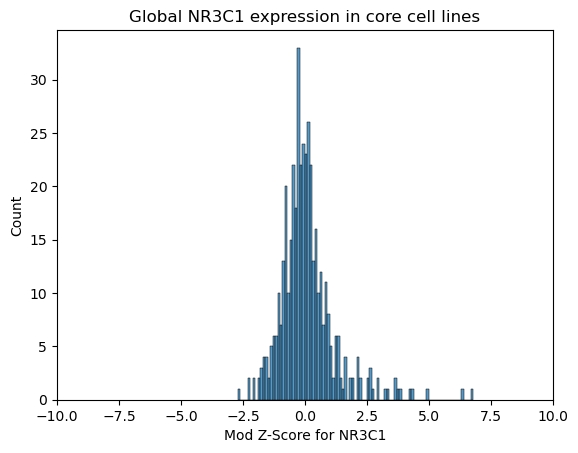

In [53]:
sample_data = sample_data_numerical.data_df

cell_sig_ids = siginfo_sample.loc[
  siginfo_sample.cell_iname.eq('MCF7')
].sig_id.unique()  #Get sig_ids for cell line

global_genemod = sample_data.loc[str(target_gene_id), :] #Extract correlations for target
sns.histplot(global_genemod, 
              binwidth=0.1).set_xlim(-10, 10)

plt.title('Global {} expression in core cell lines'.format(target))
plt.xlabel('Mod Z-Score for {}'.format(target))
plt.show()

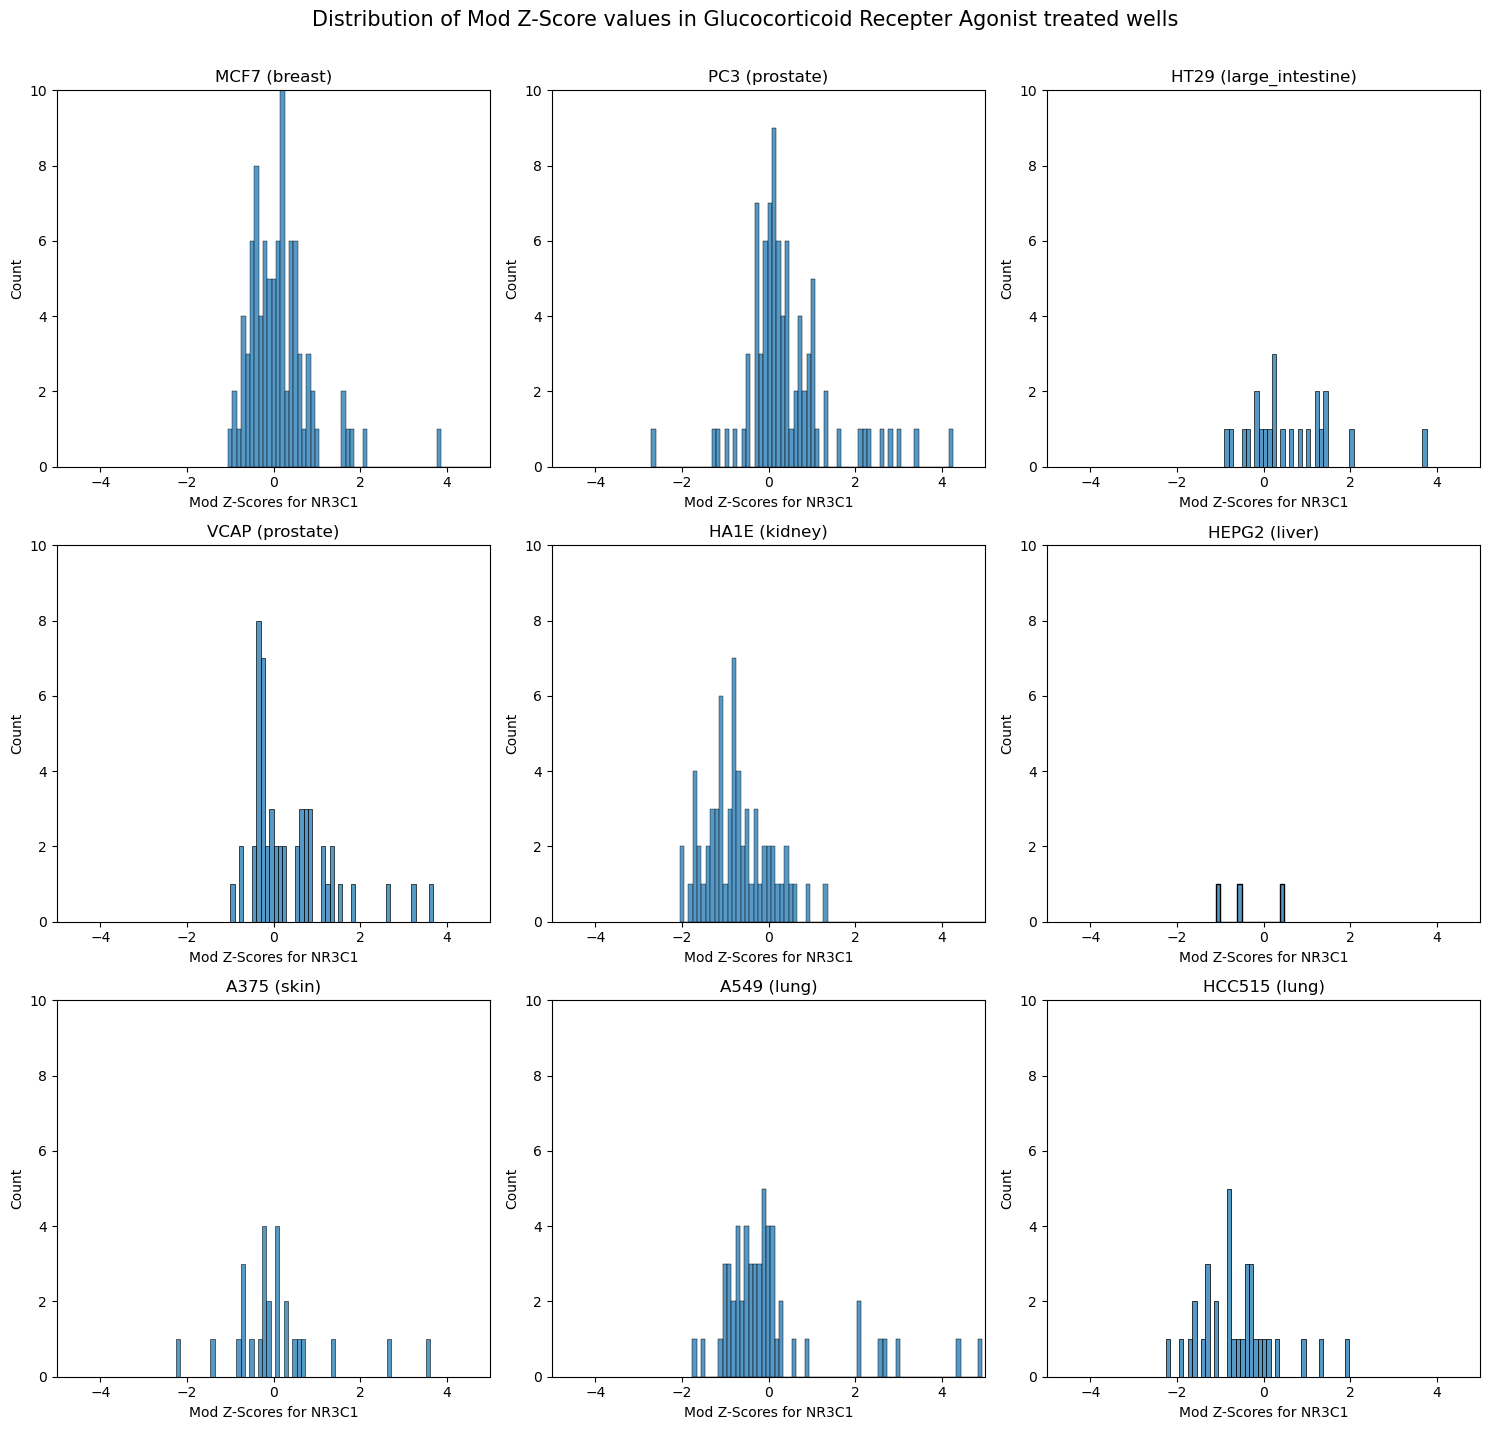

In [49]:
genemod_histograms_by_cell(sample_data, 
                           siginfo_sample, 
                           core_cellinfo, 
                           cell_list,
                           target=target, 
                           level='level5',
                           xlim=[-5,5],
                           metric_label='Mod Z-Scores',
                           plot_title='Distribution of Mod Z-Score values in Glucocorticoid Recepter Agonist treated wells')

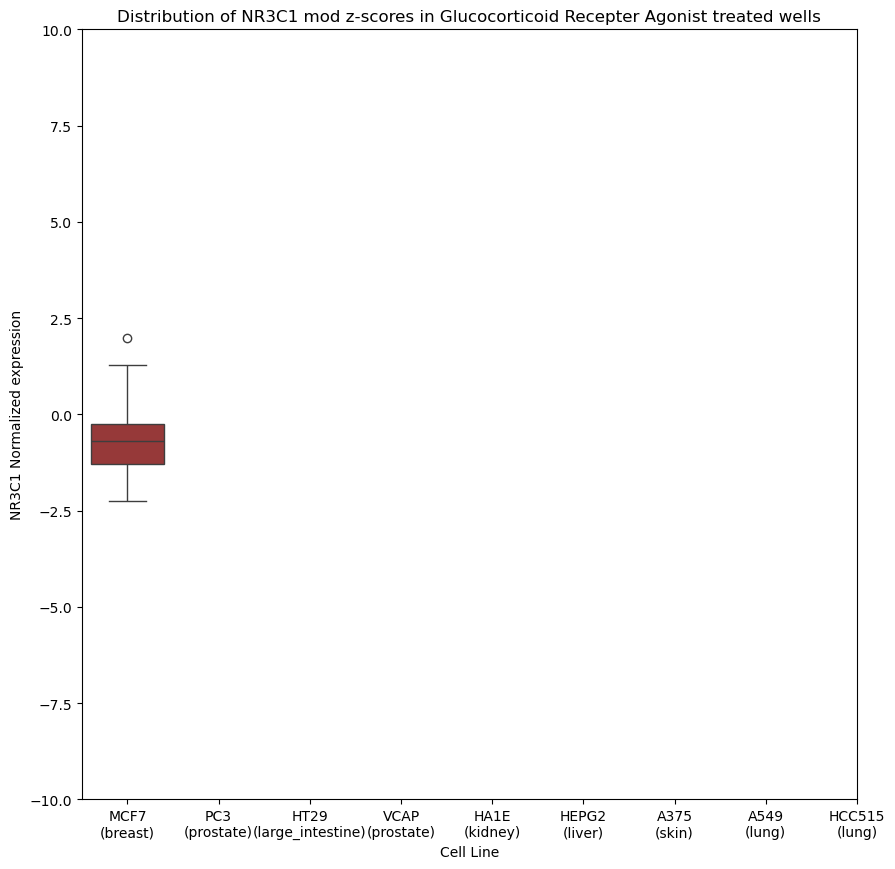

In [54]:
genemod_boxplot_by_cell(sample_data, 
                           siginfo_sample, 
                           core_cellinfo, 
                           cell_list,
                           target='NR3C1', 
                           level='level5',
                           metric_label='Normalized expression', 
                           ylim=[-10, 10],
                           plot_title='Distribution of NR3C1 mod z-scores in Glucocorticoid Recepter Agonist treated wells')

##### Comparison of Normalized Gene Expression (level 3) profiles

In [56]:
siginfo_sample.sample(5)[['distil_ids', 'det_plates']]

,distil_ids,det_plates
162,REP.A013_HA1E_24H_X1_B24:C01|REP.A013_HA1E_24H...,REP.A013_HA1E_24H_X1_B24|REP.A013_HA1E_24H_X2_...
325,REP.A003_A549_24H_X1_B27:M01|REP.A003_A549_24H...,REP.A003_A549_24H_X1_B27|REP.A003_A549_24H_X2_...
114,REP.A001_A375_24H_X1_B22:D13|REP.A001_A375_24H...,REP.A001_A375_24H_X1_B22|REP.A001_A375_24H_X2_...
43,CPC004_VCAP_24H_X1_F1B5_DUO52HI53LO:P13|CPC004...,CPC004_VCAP_24H_X1_F1B5_DUO52HI53LO|CPC004_VCA...
19,CPD003_MCF7_24H_X1_B6_DUO52HI53LO:C04|CPD003_M...,CPD003_MCF7_24H_X1_B6_DUO52HI53LO|CPD003_MCF7_...


In [58]:
distil_ids = siginfo_sample.apply(lambda row: row['distil_ids'].split('|'), axis=1)
sample_ids = [sample for id_list in distil_ids for sample in id_list]
print("Number of sig_ids: {}".format(len(siginfo_sample)))
print("Number of sample_ids: {}".format(len(sample_ids)))

Number of sig_ids: 434
Number of sample_ids: 1732


In [59]:
instinfo = cmap_query.cmap_profiles(bq_client, sample_id=sample_ids)
instinfo.sample(10)

,sample_id,det_plate,pert_id,cmap_name,pert_type,cell_iname,pert_itime,pert_idose,det_plate_1,build_name,project_code
290,CPC013_A549_24H_X3_F1B6_DUO52HI53LO:A14,CPC013_A549_24H_X3_F1B6_DUO52HI53LO,BRD-K14791739,fluticasone,trt_cp,A549,24 h,10 uM,CPC013_A549_24H_X3_F1B6_DUO52HI53LO,None,CPC
772,CPC005_A549_24H_X1_B3_DUO52HI53LO:A24,CPC005_A549_24H_X1_B3_DUO52HI53LO,BRD-A65767837,hydrocortisone-acetate,trt_cp,A549,24 h,10 uM,CPC005_A549_24H_X1_B3_DUO52HI53LO,None,CPC
1369,CPC004_PC3_24H_X4_B4_DUO52HI53LO:P13,CPC004_PC3_24H_X4_B4_DUO52HI53LO,BRD-A01643550,prednisolone-acetate,trt_cp,PC3,24 h,10 uM,CPC004_PC3_24H_X4_B4_DUO52HI53LO,None,CPC
1170,CPC005_HT29_24H_X3_B3_DUO52HI53LO:P24,CPC005_HT29_24H_X3_B3_DUO52HI53LO,BRD-A77824596,fluocinolone-acetonide,trt_cp,HT29,24 h,10 uM,CPC005_HT29_24H_X3_B3_DUO52HI53LO,None,CPC
54,REP.A018_HT29_24H_X1_B23:B19,REP.A018_HT29_24H_X1_B23,BRD-K62310379,fluticasone-propionate,trt_cp,HT29,24 h,10 uM,REP.A018_HT29_24H_X1_B23,None,REP
1596,CPC020_VCAP_24H_X4_B5_DUO52HI53LO:B14,CPC020_VCAP_24H_X4_B5_DUO52HI53LO,BRD-K73978287,hydrocortisone,trt_cp,VCAP,24 h,10 uM,CPC020_VCAP_24H_X4_B5_DUO52HI53LO,None,CPC
2,LKCP002_A549_24H_X5_B41:P13,LKCP002_A549_24H_X5_B41,BRD-K35240538,methylprednisolone,trt_cp,A549,24 h,10 uM,LKCP002_A549_24H_X5_B41,None,LKCP
1021,CRCGN001_HA1E_24H_X3_F1B4_DUO52HI53LO:J21,CRCGN001_HA1E_24H_X3_F1B4_DUO52HI53LO,BRD-A35108200,dexamethasone,trt_cp,HA1E,24 h,20 uM,CRCGN001_HA1E_24H_X3_F1B4_DUO52HI53LO,None,CRCGN
1394,CPC011_PC3_24H_X1_B3_DUO52HI53LO:F16,CPC011_PC3_24H_X1_B3_DUO52HI53LO,BRD-K39983086,loteprednol,trt_cp,PC3,24 h,10 uM,CPC011_PC3_24H_X1_B3_DUO52HI53LO,None,CPC
263,CPC002_HCC515_24H_X2_B3_DUO52HI53LO:C11,CPC002_HCC515_24H_X2_B3_DUO52HI53LO,BRD-K39188321,betamethasone,trt_cp,HCC515,24 h,10 uM,CPC002_HCC515_24H_X2_B3_DUO52HI53LO,None,CPC


Running query ... (1/2)
Total bytes processed: 9.8GiB
Total bytes billed: 9.8GiB
Running query ... (2/2)
Total bytes processed: 8.5GiB
Total bytes billed: 8.5GiB
Pivoting Dataframes to GCT objects
Complete


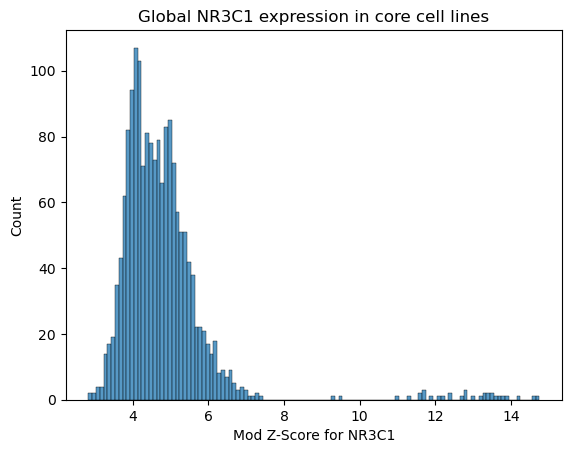

In [60]:
level3_data = cmap_query.cmap_matrix(bq_client, data_level='level3', cid=instinfo.sample_id.to_list(), limit=len(instinfo))
level3_clustered_matrix = cluster_corr(level3_data.data_df.corr())
global_genemod = level3_data.data_df.loc[str(target_gene_id), :] #Extract correlations for cell line
sns.histplot(global_genemod, 
              binwidth=0.1)

plt.title('Global {} expression in core cell lines'.format(target))
plt.xlabel('Mod Z-Score for {}'.format(target))
plt.show()

Histograms

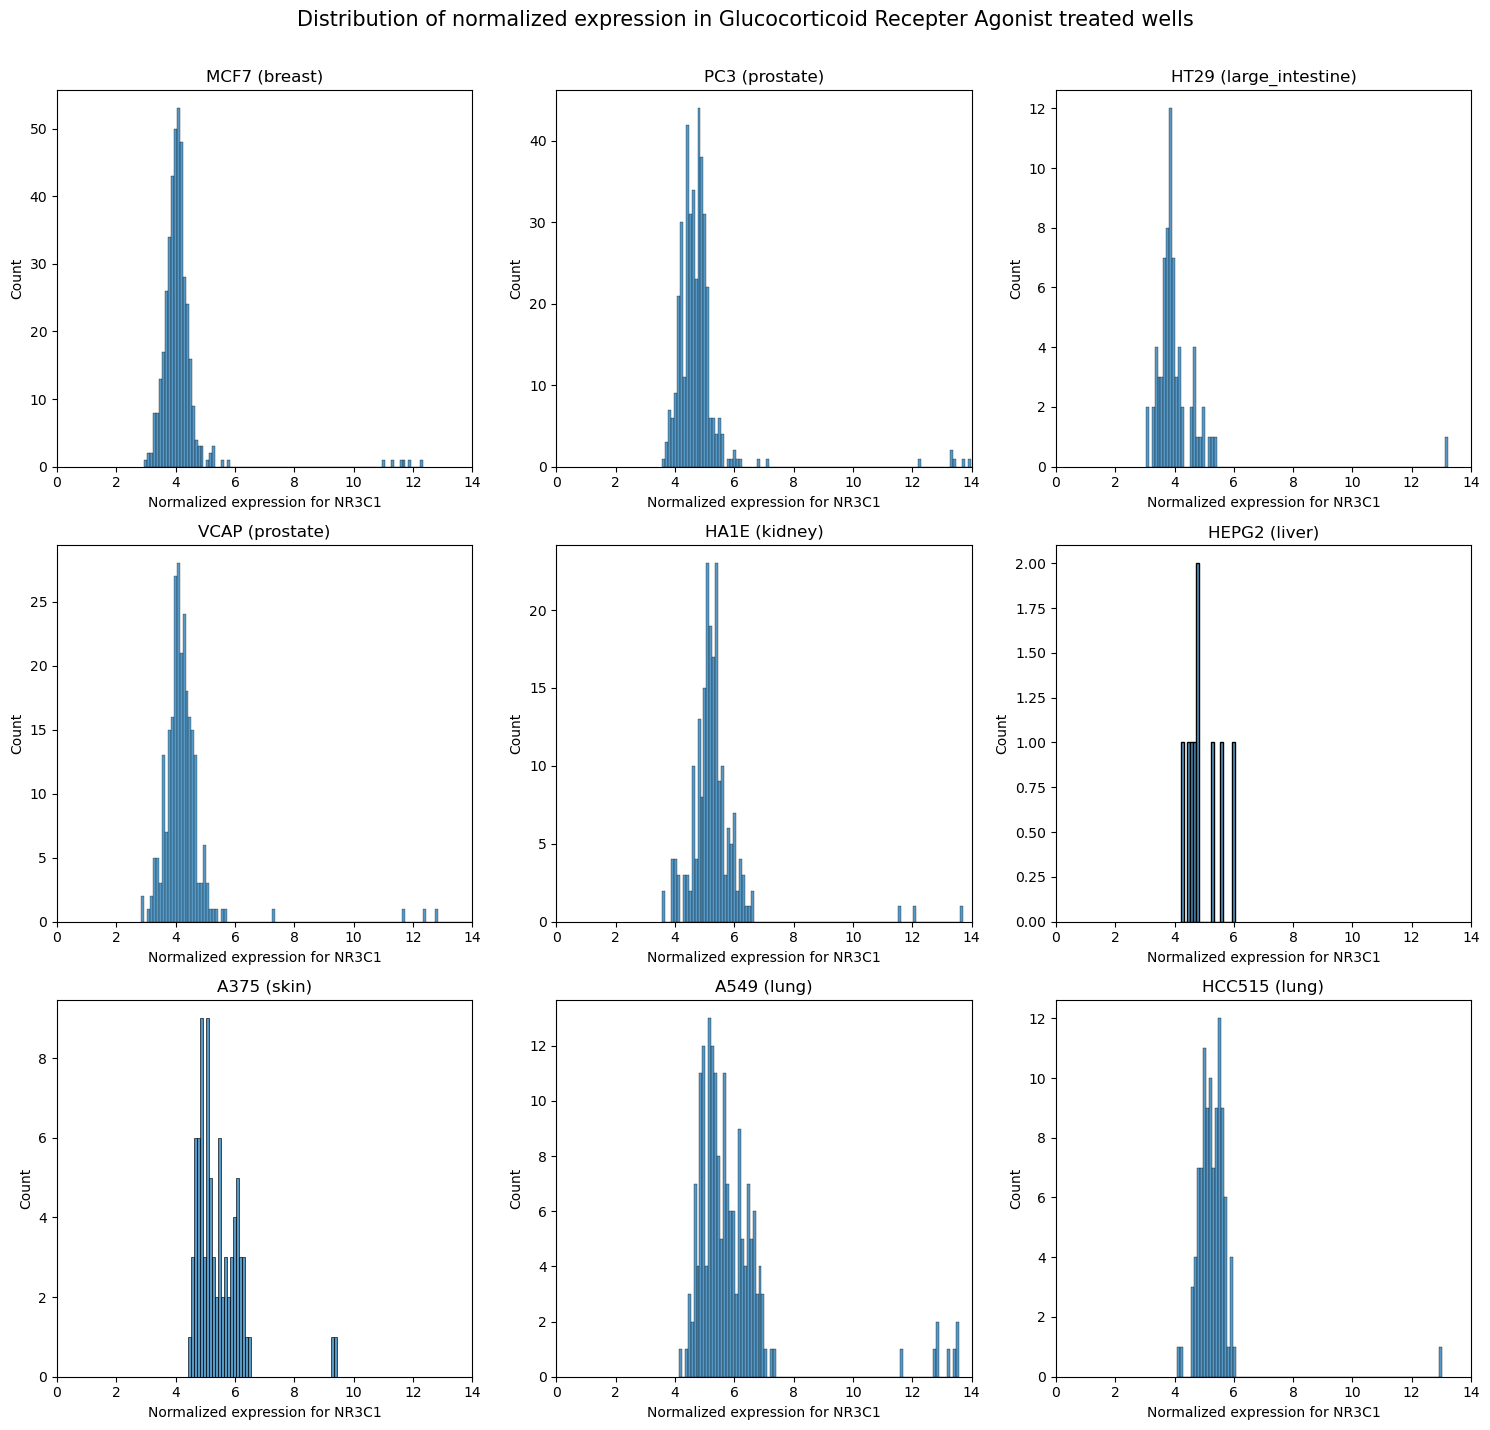

In [61]:
genemod_histograms_by_cell(level3_data.data_df,
                           instinfo,
                           core_cellinfo,
                           cell_order=cell_list,
                           target=target,
                           level='level3',
                           xlim=[0, 14],
                           ylim=None,
                           metric_label='Normalized expression', 
                           plot_title='Distribution of normalized expression in Glucocorticoid Recepter Agonist treated wells')

Boxplots

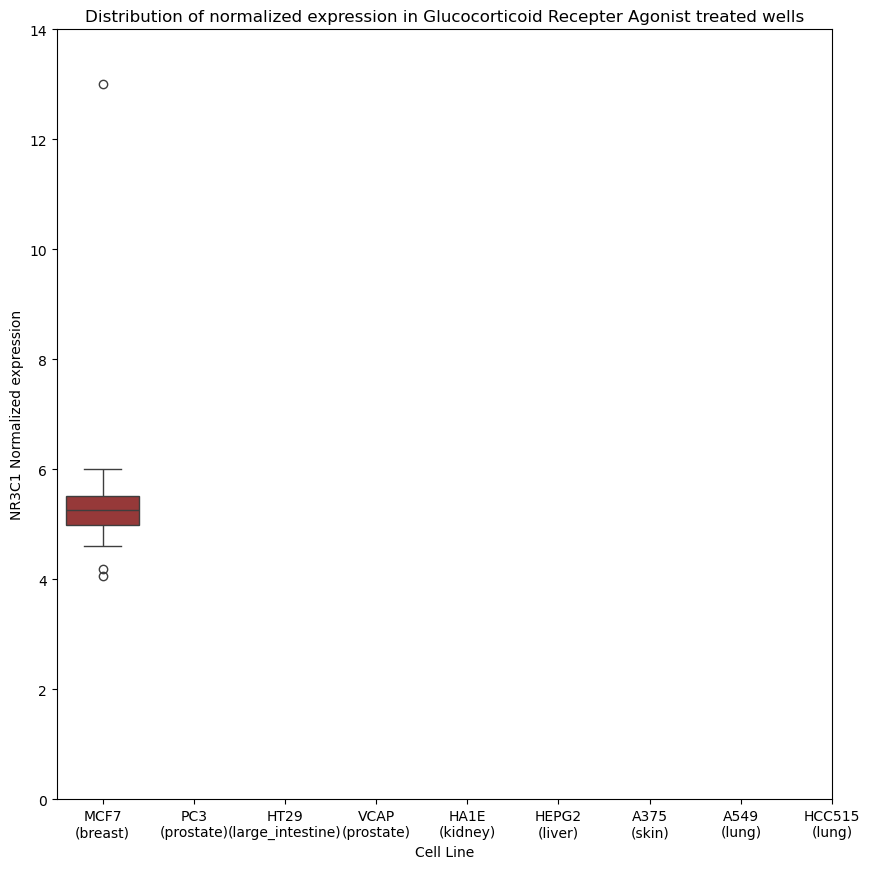

In [62]:
genemod_boxplot_by_cell(level3_data.data_df,
                           instinfo,
                           core_cellinfo,
                           cell_order=cell_list,
                           target=target,
                           level='level3',
                           metric_label='Normalized expression', 
                           plot_title='Distribution of normalized expression in Glucocorticoid Recepter Agonist treated wells')

#### Comparison of Target Gene Expression in Control Wells

In [63]:
# get data for control wells within the same plate as treatments
print("Number of unique plates: {}".format(len(instinfo.det_plate.unique())))

Number of unique plates: 443


In [64]:
types = [
         'ctl_vehicle', 
#         'ctl_untrt'
    ]

ctl_instinfo = cmap_query.cmap_profiles(bq_client, pert_type=types , det_plate=list(instinfo.det_plate.unique()))

print("Length of ctl instinfo: {}".format(len(ctl_instinfo)))

Length of ctl instinfo: 6814


In [65]:
ctl_instinfo.sample(10)

,sample_id,det_plate,pert_id,cmap_name,pert_type,cell_iname,pert_itime,pert_idose,det_plate_1,build_name,project_code
3056,REP.A003_HA1E_24H_X1_B22:F08,REP.A003_HA1E_24H_X1_B22,DMSO,DMSO,ctl_vehicle,HA1E,24 h,None,REP.A003_HA1E_24H_X1_B22,None,REP
2655,REP.A028_A549_24H_X3_B29:J17,REP.A028_A549_24H_X3_B29,DMSO,DMSO,ctl_vehicle,A549,24 h,None,REP.A028_A549_24H_X3_B29,None,REP
1355,REP.A013_A375_24H_X3_B24:A03,REP.A013_A375_24H_X3_B24,DMSO,DMSO,ctl_vehicle,A375,24 h,None,REP.A013_A375_24H_X3_B24,None,REP
1103,CPC010_PC3_24H_X2_B5_DUO52HI53LO:K02,CPC010_PC3_24H_X2_B5_DUO52HI53LO,DMSO,DMSO,ctl_vehicle,PC3,24 h,None,CPC010_PC3_24H_X2_B5_DUO52HI53LO,None,CPC
1749,REP.A013_A375_24H_X1_B24:F10,REP.A013_A375_24H_X1_B24,DMSO,DMSO,ctl_vehicle,A375,24 h,None,REP.A013_A375_24H_X1_B24,None,REP
2027,REP.A010_A549_24H_X3_B32:J18,REP.A010_A549_24H_X3_B32,DMSO,DMSO,ctl_vehicle,A549,24 h,None,REP.A010_A549_24H_X3_B32,None,REP
2940,CPC003_HA1E_24H_X2_B3_DUO52HI53LO:F05,CPC003_HA1E_24H_X2_B3_DUO52HI53LO,DMSO,DMSO,ctl_vehicle,HA1E,24 h,None,CPC003_HA1E_24H_X2_B3_DUO52HI53LO,None,CPC
1182,REP.A001_PC3_24H_X2_B22:F08,REP.A001_PC3_24H_X2_B22,DMSO,DMSO,ctl_vehicle,PC3,24 h,None,REP.A001_PC3_24H_X2_B22,None,REP
1741,REP.A024_A375_24H_X1_B23:B05,REP.A024_A375_24H_X1_B23,DMSO,DMSO,ctl_vehicle,A375,24 h,None,REP.A024_A375_24H_X1_B23,None,REP
3713,REP.A001_HA1E_24H_X3_B22:F09,REP.A001_HA1E_24H_X3_B22,DMSO,DMSO,ctl_vehicle,HA1E,24 h,None,REP.A001_HA1E_24H_X3_B22,None,REP


In [66]:
ctl_data = cmap_query.cmap_matrix(bq_client, data_level='level3', cid=list(ctl_instinfo.sample_id), limit=10000)

target_ctl_genemod = ctl_data.data_df.loc[str(target_gene_id), :]

Running query ... (1/7)
Total bytes processed: 2.3GiB
Total bytes billed: 2.3GiB
Running query ... (2/7)
Total bytes processed: 3.6GiB
Total bytes billed: 3.6GiB
Running query ... (3/7)
Total bytes processed: 2.8GiB
Total bytes billed: 2.8GiB
Running query ... (4/7)
Total bytes processed: 2.5GiB
Total bytes billed: 2.5GiB
Running query ... (5/7)
Total bytes processed: 3.4GiB
Total bytes billed: 3.4GiB
Running query ... (6/7)
Total bytes processed: 3.8GiB
Total bytes billed: 3.8GiB
Running query ... (7/7)
Total bytes processed: 1.9GiB
Total bytes billed: 1.9GiB
Pivoting Dataframes to GCT objects
Complete


Histograms

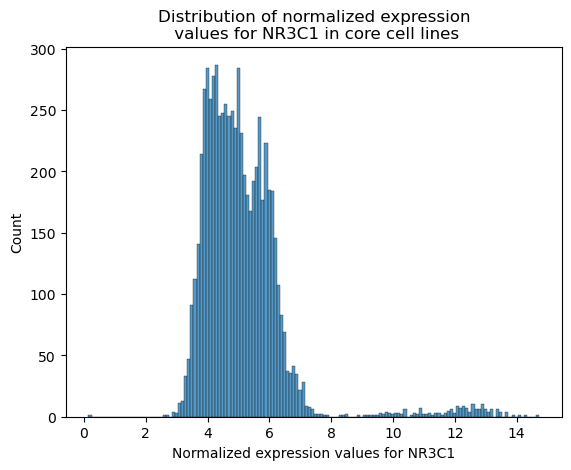

In [67]:
sns.histplot(target_ctl_genemod, 
              binwidth=0.1)

plt.title('Distribution of normalized expression\n values for {} in core cell lines'.format(target))
plt.xlabel('Normalized expression values for {}'.format(target))
plt.show()

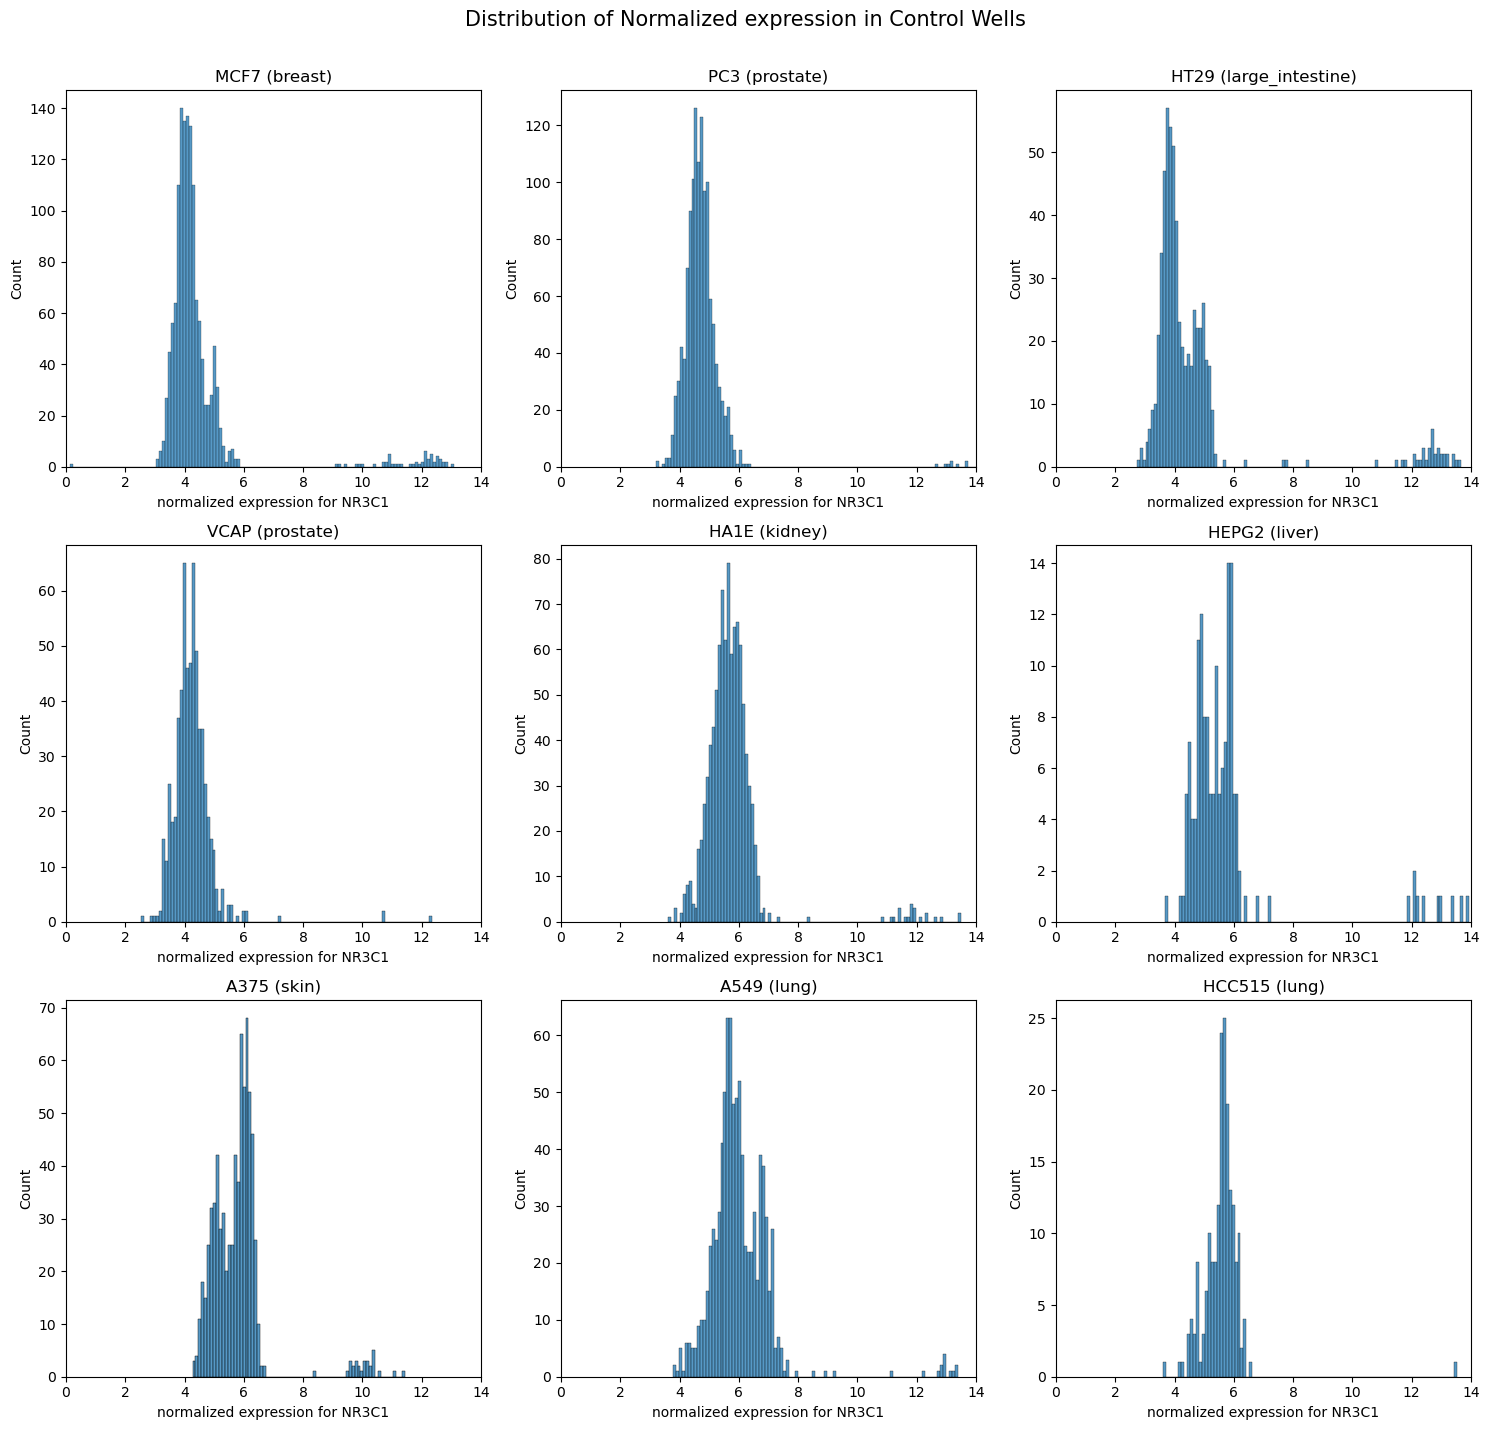

In [68]:
genemod_histograms_by_cell(ctl_data.data_df,
                           ctl_instinfo,
                           core_cellinfo,
                           cell_list,
                           target=target,
                           level='level3',
                           xlim=[0,14], ylim=None,
                           metric_label='normalized expression',
                           plot_title='Distribution of Normalized expression in Control Wells')

Boxplots

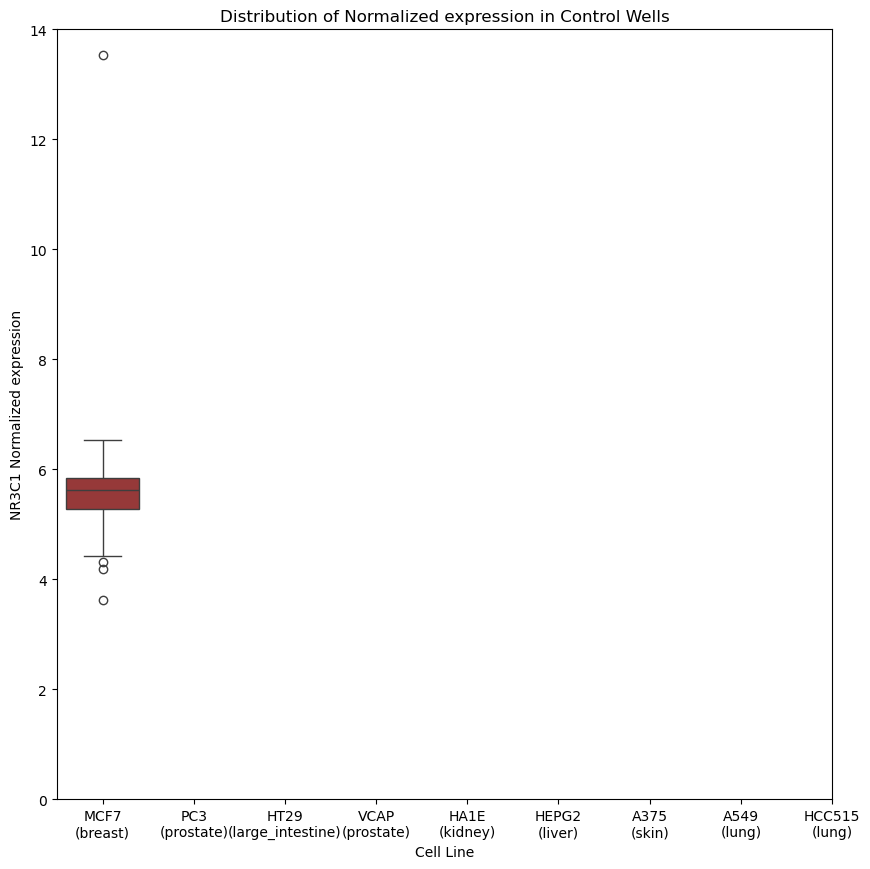

In [70]:
genemod_boxplot_by_cell(ctl_data.data_df,
                           ctl_instinfo,
                           core_cellinfo,
                           cell_order=cell_list,
                           target=target,
                           level='level3',
                           metric_label='Normalized expression',
                           plot_title='Distribution of Normalized expression in Control Wells')